0/16 ; 0/16


c:\users\yara\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0/16 ; 1/16
0/16 ; 2/16
0/16 ; 3/16
0/16 ; 4/16
0/16 ; 5/16
0/16 ; 6/16
0/16 ; 7/16
0/16 ; 8/16
0/16 ; 9/16
0/16 ; 10/16
0/16 ; 11/16
0/16 ; 12/16
0/16 ; 13/16
0/16 ; 14/16
0/16 ; 15/16
1/16 ; 0/16
1/16 ; 1/16
1/16 ; 2/16
1/16 ; 3/16
1/16 ; 4/16
1/16 ; 5/16
1/16 ; 6/16
1/16 ; 7/16
1/16 ; 8/16
1/16 ; 9/16
1/16 ; 10/16
1/16 ; 11/16
1/16 ; 12/16
1/16 ; 13/16
1/16 ; 14/16
1/16 ; 15/16
2/16 ; 0/16
2/16 ; 1/16
2/16 ; 2/16
2/16 ; 3/16
2/16 ; 4/16
2/16 ; 5/16
2/16 ; 6/16
2/16 ; 7/16
2/16 ; 8/16
2/16 ; 9/16
2/16 ; 10/16
2/16 ; 11/16
2/16 ; 12/16
2/16 ; 13/16
2/16 ; 14/16
2/16 ; 15/16
3/16 ; 0/16
3/16 ; 1/16
3/16 ; 2/16
3/16 ; 3/16
3/16 ; 4/16
3/16 ; 5/16
3/16 ; 6/16
3/16 ; 7/16
3/16 ; 8/16
3/16 ; 9/16
3/16 ; 10/16
3/16 ; 11/16
3/16 ; 12/16
3/16 ; 13/16
3/16 ; 14/16
3/16 ; 15/16
4/16 ; 0/16
4/16 ; 1/16
4/16 ; 2/16
4/16 ; 3/16
4/16 ; 4/16
4/16 ; 5/16
4/16 ; 6/16
4/16 ; 7/16
4/16 ; 8/16
4/16 ; 9/16
4/16 ; 10/16
4/16 ; 11/16
4/16 ; 12/16
4/16 ; 13/16
4/16 ; 14/16
4/16 ; 15/16
5/16 ; 0/16
5/16 ; 1/1

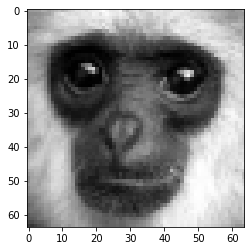

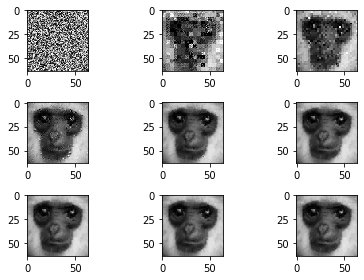

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #Exibir imagem
from scipy import ndimage #Processar imagem multidimensional
from scipy import optimize #Otimização
import numpy as np
import math


def get_greyscale_image(img):
    return np.mean(img[:,:,:2], 2)

# Transformações

#redução da imagem 

def reduce(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

#rotação

def rotate(img, angle):
    return ndimage.rotate(img, angle, reshape=False)

#Função giro

def flip(img, direction):
    return img[::direction,:]


#conversão completa

def apply_transformation(img, direction, angle, contrast=1.0, brightness=0.0):
    return contrast*rotate(flip(img, direction), angle) + brightness

# Contraste e brilho

def find_contrast_and_brightness1(D, S):
    #Corrigir o contraste e ajustando somente o brilho
    contrast = 0.75
    brightness = (np.sum(D - contrast*S)) / D.size
    return contrast, brightness 

def find_contrast_and_brightness2(D, S):
    #Ajuste do contraste e o brilho
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b)
    return x[1], x[0]

# Compressão para imagens greyscale 

def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            #Extraindo o bloco de origem e reduzindo a forma de um bloco de destino
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            #Gerando todos os blocos transformados possíveis
            for direction, angle in candidates:
                transformed_blocks.append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        for j in range(j_count):
            print("{}/{} ; {}/{}".format(i, i_count, j, j_count))
            transformations[i].append(None)
            min_d = float('inf')
            #Extraindo o bloco de destino
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            #Testando todas as transformações possíveis e pegando a melhor
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                #Parte onde se aplica as transformações
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations

#Plotagem 

def plot_iterations(iterations, target=None):
    #Configuração
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    #Plotagem
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        if target is None:
            plt.title(str(i))
    plt.tight_layout()

# Parametros

directions = [1, -1]
angles = [0, 90, 180, 270]

# Teste da imagem greyscale

def test_greyscale():
    img = mpimg.imread('monkey.gif')
    img = get_greyscale_image(img)
    img = reduce(img, 4)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    transformations = compress(img, 8, 4, 8)
    iterations = decompress(transformations, 8, 4, 8)
    plot_iterations(iterations, img)
    plt.show()
                    
if __name__ == '__main__':
    test_greyscale()
    